In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO

def group_cols(df, cols, gn):
    s = df[cols[0]]
    for c in cols[1:]:
        s = s + df[c]
    df[gn] = s
    return df.drop(columns=cols)

def filter(csv, col):
    dropped = ['dc', 'rad', 'rea', 'hosp']
    dropped.remove(col)
    temp = csv[csv['reg'] != 0].groupby(['jour', 'reg', 'cl_age90']).\
        sum().\
        drop(columns=dropped).\
        unstack('cl_age90').\
        groupby('jour').\
        sum()
    temp.columns = [x for _, x in temp.columns]
    temp = group_cols(temp, [9, 19, 29, 39, 49], 0)
    temp = group_cols(temp, [89, 90], 99)
    temp = temp.reindex(sorted(temp.columns), axis=1)
    temp.columns = ['Moins de 50 ans', '50 à 59 ans',
                    '60 à 69 ans', '70 à 79 ans', 'plus de 80 ans']
    return temp

req = requests.get('https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3')
csv = pd.read_csv(StringIO(req.text), delimiter=';', parse_dates=['jour'])

Population totale = 68966596


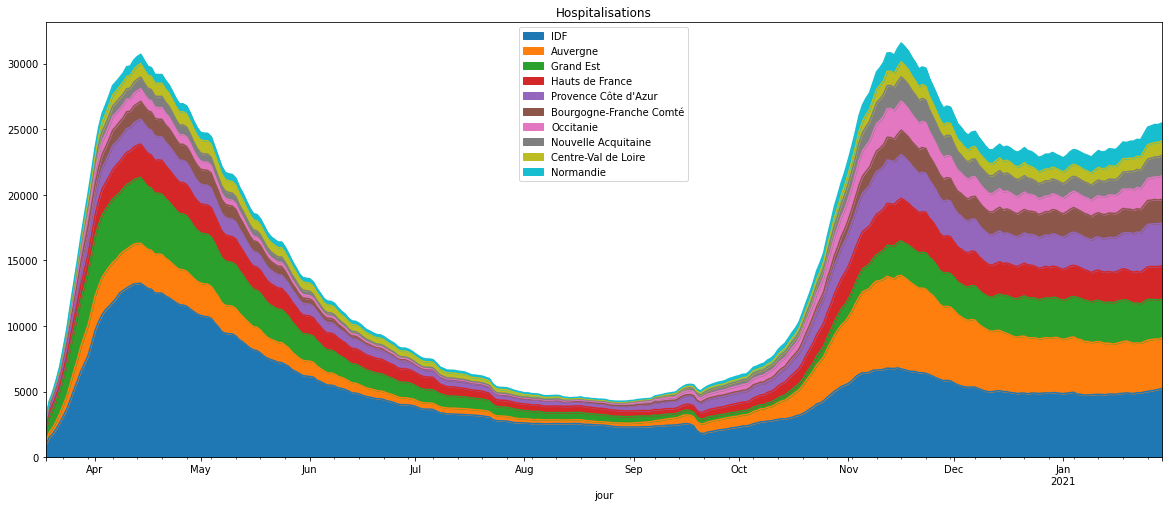

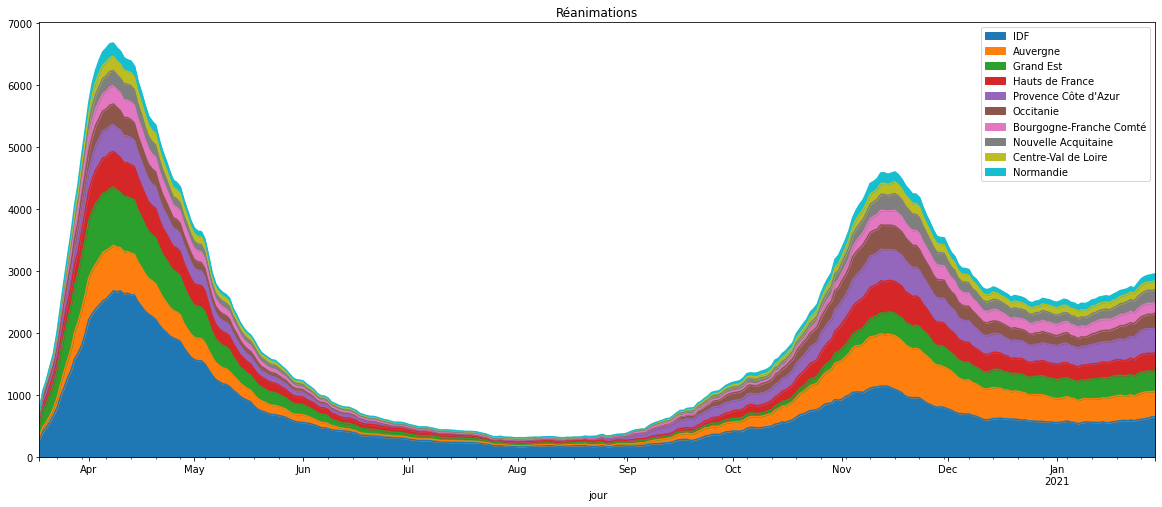

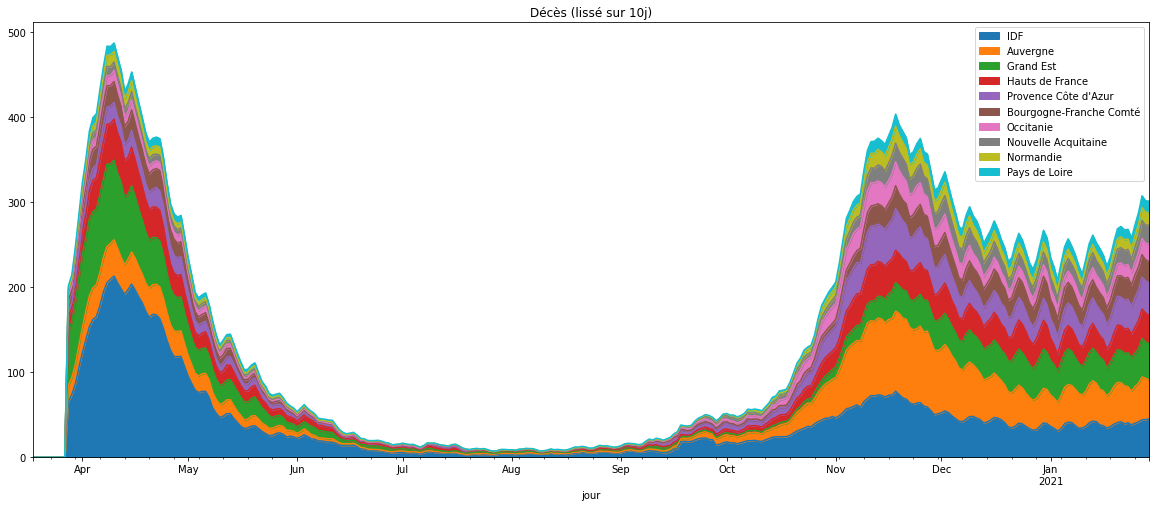

In [2]:
REGIONS={
    11:["IDF", 12_213_447], 
    24: ["Centre-Val de Loire", 2_572_853],
    27: ["Bourgogne-Franche Comté", 2_807_807],
    28: ["Normandie", 3_499_280],
    3: ["Nord Pas de Calais", 4_050_756],
    32: ["Hauts de France", 6_004_108],
    44: ["Grand Est", 5_550_389],
    52: ["Pays de Loire", 3_781_423],
    53: ["Bretagne", 3_335_414],
    75: ["Nouvelle Acquitaine", 5_879_778],
    76: ["Occitanie", 5_885_496],
    84: ["Auvergne", 7_994_459],
    93: ["Provence Côte d'Azur", 5_052_832],
    94: ["Corse", 338_554]
    }
# regions to be grouped together
MIX =[(2, 24), (1,11), (4, 44), (6, 75)]

reg = pd.DataFrame(REGIONS, index=['nom','population']).T
population = int(reg.population.sum())
print(f"Population totale = {population}")

def plot_par_region(title, col):
    df = csv[csv['cl_age90'] == 0][['jour', 'reg', col]]
    df = df.pivot(index='jour', columns='reg')
    if col == 'dc':
        df = df.diff().rolling(10).mean().clip(0)

    # group some region together
    df.set_axis([y for x, y in df.columns], axis=1, inplace=True)
    for c1, c2 in MIX:
        df[c2] = df[c2]+df[c1]
        df = df.drop(columns=[c1])

    # rename the columns
    # correct relative to the population (disabled)
    df.set_axis([REGIONS.get(y, [str(y)])[0] for y in df.columns], axis=1, inplace=True)
    for c in df.columns:
        try:
            pop = reg.population[reg.nom==c].values[0]
            #print(c, reg.population[reg.nom==c].values)
        except Exception as err:
            pop=1
            print(c)
        #print(c, pop)
        #df[c] = df[c].astype(float).divide(pop).multiply(population)

    s=df.sum()
    df=df[s.sort_values(ascending=False).index[:10]]
    df.plot.area(figsize=(20,8), title=title)

plot_par_region("Hospitalisations", 'hosp')
plot_par_region("Réanimations", 'rea')
plot_par_region("Décès (lissé sur 10j)", 'dc')
